In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import h5py
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import entropy

In [33]:
h5_files = {
    1: 'Image1.h5',
    2: 'Image2.h5',
    3: 'Image3.h5'
}

keys_template = ['img{n}_camera_image', 'img{n}_R-L', 'img{n}_MEF', 'img{n}_CFCNN', 'img{n}_ground_truth']

images = []

for n in [1, 2, 3]:
    with h5py.File(h5_files[n], 'r') as h5f:
        row = [np.array(h5f[key.format(n=n)]) for key in keys_template]
        images.append(row)

In [34]:
def norm(a):
    asu = a - np.min(a)
    norm = np.sum(asu)
    if norm == 0:
        return np.zeros_like(a)
    return asu/norm

In [35]:
# Normalization of the images and blurring by a narrow Gaussian filter for visualisation purposes. The blurring does not involve the input camera image.

noblur_index = 0
blur_sigma = 2

blurred_normalized_images = []
for row in images:
    processed_row = []
    for i, img in enumerate(row):
        if i != noblur_index:
            img = ndi.gaussian_filter(img, sigma=blur_sigma)
        img = norm(img)
        processed_row.append(img)
    blurred_normalized_images.append(processed_row)

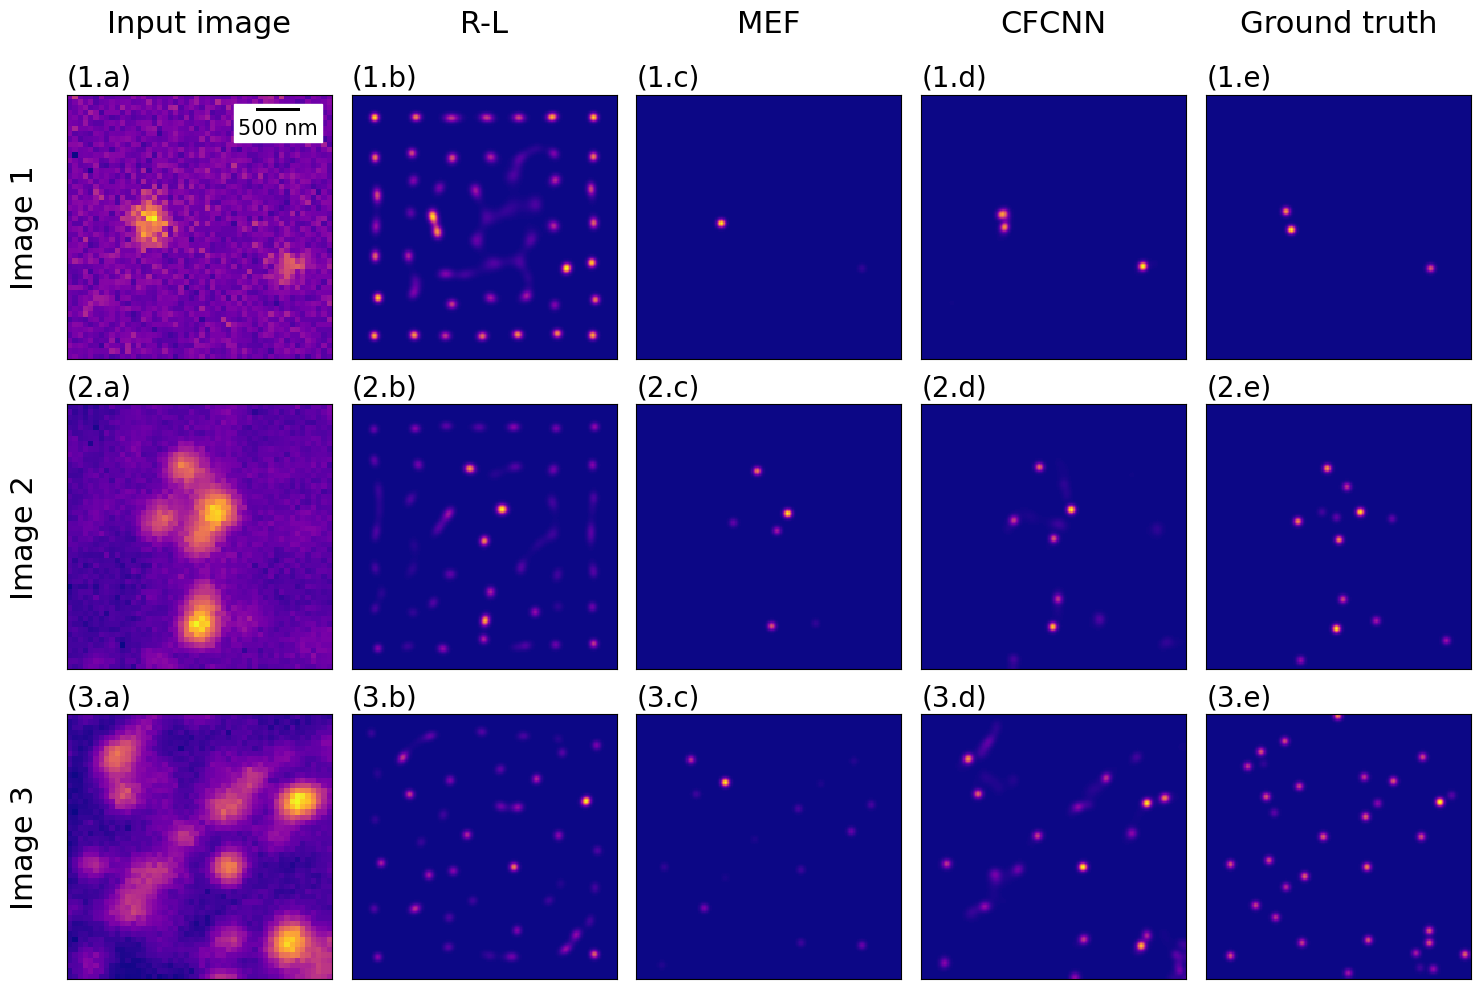

In [36]:
# Recreation of the Figure 2 

fig, ax = plt.subplots(3, 5, figsize=(15,10))

column_labels = ['a', 'b', 'c', 'd', 'e']
row_labels = ['1', '2', '3', '5'] 

column_titles = ['Input image', 'R-L', 'MEF', 'CFCNN', 'Ground truth']
row_titles = ['Image 1', 'Image 2', 'Image 3']

for i in range(3):
    for j in range(5):
        ax[i, j].matshow(blurred_normalized_images[i][j], cmap="plasma")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        label = f'{i+1}.{column_labels[j]}'

        if i == 0 and j == 0:  
            scalebar = ScaleBar(0.060, units="µm", location='upper right', pad=0.3, border_pad=0.7, font_properties={"size": 15}) 
            ax[i, j].add_artist(scalebar)

        # Add text label to each subplot
        ax[i, j].text(
            0, 1.01, 
            f'({label})',  
            transform=ax[i, j].transAxes, 
            fontsize=20,
            va='bottom', ha='left'        
        )

for j, title in enumerate(column_titles):
       ax[0, j].set_title(title, fontsize=22, pad=45)

for i, title in enumerate(row_titles):
    ax[i, 0].set_ylabel(title, fontsize=22, rotation=90, labelpad=20)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()

plt.show()

In [37]:
# Definition of the mean absolute error between two images (imB corresponds to the ground truth)

def MAE(imA, imB, blur=2):
    imAn = norm(ndi.gaussian_filter(imA, blur))
    imBn = norm(ndi.gaussian_filter(imB, blur))
    return np.mean(np.abs(imAn.ravel() - imBn.ravel()))


# Definition of the Kullback-Leibler divergence between two images (imB corresponds to the ground truth); the order is important

def KLD(imA, imB, blur=2, prevent_infty=True):
    imAn = norm(ndi.gaussian_filter(imA, blur).ravel()) #+ 1e-9 #tested distribution
    if prevent_infty:
        imAn += 1e-16
        imAn /= np.sum(imAn)
    imBn = norm(ndi.gaussian_filter(imB, blur).ravel()) #+ 1e-9 #reference distribution    

    return entropy(imBn/np.sum(imBn), imAn/np.sum(imAn), base=2)

In [39]:
# Calculation of the metrics between Image 1, Image 2, Image 3 and the corresponding ground truths

for row_idx, row in enumerate(images):
    #reference = row[4]  # ground truth is the last image in each row
    reference = row[-1]  # ground truth is the last image in each row
    dataset_number = [1, 2, 3][row_idx]

    print(f"\n--- Metrics for Image{dataset_number} vs. ground truth ---")
    
    # First row: MAE
    mae_values = [MAE(reference, row[i]) * 1e5 for i in [1, 2, 3]]
    mae_row = "  MAE [×10⁻⁵]: " + "  ".join(f"{mae:.2f}" for mae in mae_values)
    print(mae_row)

    # Second row: KLD
    kld_values = [KLD(row[i], reference) for i in [1, 2, 3]]
    kld_row = "  KLD:         " + "  ".join(f"{kld:.2f}" for kld in kld_values)
    print(kld_row)


--- Metrics for Image1 vs. ground truth ---
  MAE [×10⁻⁵]: 4.64  3.99  2.41
  KLD:         5.81  12.60  1.08

--- Metrics for Image2 vs. ground truth ---
  MAE [×10⁻⁵]: 3.98  3.56  2.27
  KLD:         7.76  17.27  2.10

--- Metrics for Image3 vs. ground truth ---
  MAE [×10⁻⁵]: 3.52  4.01  3.34
  KLD:         10.03  19.04  5.22
